In [59]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

import cv2

In [60]:
df_train = pd.read_csv("data/train.csv")

cl_type = dict(df_train.dtypes)
cl_type = {k:str(v) for k, v in cl_type.items()}
cl_type = [x for x in cl_type.keys() if cl_type[x] == 'int64']

In [61]:
df_train_sum_type = df_train.sum(axis=0)[cl_type]
df_train_sum_type = df_train_sum_type.sort_values(ascending=False)
df_train_sum_type = pd.DataFrame(df_train_sum_type, columns = ["count"])
df_train_sum_type = df_train_sum_type.reset_index()

colors = cm.hsv(np.linspace(0,1,len(df_train_sum_type), endpoint=False))
df_train_sum_type["color"] = df_train_sum_type.apply(
    lambda x: cm.hsv(x.name / len(df_train_sum_type)), axis=1
)

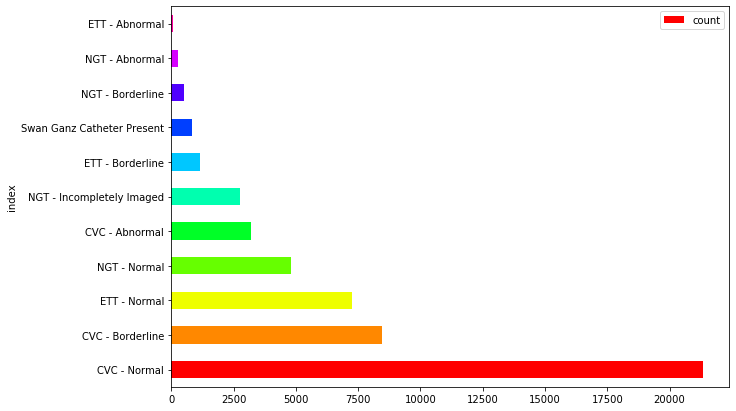

In [62]:
fig, ax = plt.subplots(figsize=(10, 7))

df_train_sum_type.plot.barh(x="index", y="count", ax=ax, color=df_train_sum_type["color"])
plt.show()

In [63]:
df_annot = pd.read_csv("data/train_annotations.csv")

df_annot_unique = pd.DataFrame(columns = ["StudyInstanceUID", "index_list"])
df_annot_unique["StudyInstanceUID"] = df_annot["StudyInstanceUID"].drop_duplicates()
df_annot_unique["index_list"] = df_annot_unique.apply(lambda x: list(df_annot.loc[df_annot["StudyInstanceUID"] == x["StudyInstanceUID"], ].index), axis=1)

In [64]:
def parse_array(data):
    data = data.replace("[", "").replace("]]", "]").split("], ")
    data = np.array([x.replace("]", "").split(", ") for x in data]).astype(int)
    return data

# df_annot row
def draw_singlerow(row, size=10, color=(255,0,0)):
    image = cv2.imread(f"data/train/{row['StudyInstanceUID']}.jpg")
    legend_items = [
        Line2D([0], [0], marker='o', color="w", label=row['label'], 
        markerfacecolor=(color[0]/255, color[1]/255, color[2]/255, 1.), markersize=8)]

    data = parse_array(row["data"])
    for point in data:
        image = cv2.circle(image, (point[0], point[1]), size, color, -1)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(row["StudyInstanceUID"])
    ax.legend(handles=legend_items)
    plt.show()

    return image

# df_annot_unique row
def draw_multirow(row):
    image = cv2.imread(f"data/train/{row['StudyInstanceUID']}.jpg")

    subset = df_annot.loc[row["index_list"]]
    for index, subrow in subset.iterrows():
        data = parse_array(subrow["data"])
        color = df_train_sum_type.loc[df_train_sum_type["index"] == subrow["label"], "color"].iloc[0]
        for point in data:
            image = cv2.circle(image, (point[0], point[1]), 10,
            (int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)), -1)

    legend_items = []
    for label in subset["label"].drop_duplicates():
        color = df_train_sum_type.loc[df_train_sum_type["index"] == label, "color"].iloc[0]
        legend_items.append(
            Line2D([0], [0], marker='o', color="w", label=label, 
            markerfacecolor=(color[0], color[1], color[2], 1.), markersize=8))  

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(row["StudyInstanceUID"])
    ax.legend(handles=legend_items)
    plt.show()

    return image

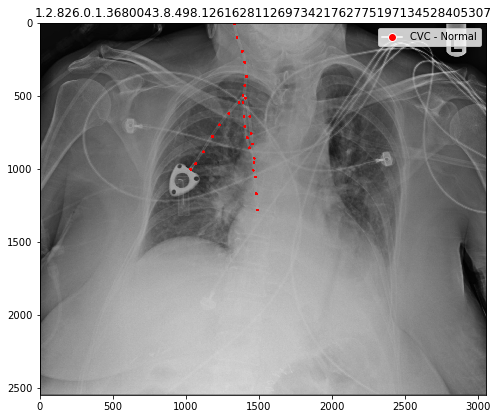

In [66]:
image = draw_multirow(df_annot_unique.iloc[0])

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from dataset import ImageDataset
from model import Detector
from util import set_requires_grad

import torch

df_train = pd.read_csv("data/train_new.csv")
val_dataset = ImageDataset("valid", 380, "data/sample_submission.csv", False, fold=0, do_transform=False)

model = Detector(0.0).cuda()
set_requires_grad([model.feature_extractor], False)

checkpoint = torch.load("logs/1e_4/checkpoint_024.pth")
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [4]:
total_result = []

model.eval()
with torch.no_grad():
    for sample in tqdm(val_dataset):
        images = sample["image"].unsqueeze(0).cuda()
        labels = sample["label"].unsqueeze(0).cuda()
        img_name = sample["img_name"]

        y = model(images)
        preds = y.sigmoid() > 0.5
        preds = list(preds.cpu().numpy().astype(int))
        preds.insert(0, img_name)
        total_result.append(preds)

  0%|          | 0/3582 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\Documents\\workspace\\ranzcr-clip\\data\\train\\1.2.826.0.1.3680043.8.498.46923145579096002617106567297135160932.jpg'

In [57]:
total_result = []

model.eval()
with torch.no_grad():
    for sample in tqdm(val_dataset):
        images = sample["image"].unsqueeze(0).cuda()
        labels = sample["label"].unsqueeze(0).cuda()
        img_name = sample["img_name"]

        y = model(images)
        preds = y.sigmoid() > 0.5
        preds = list(preds.cpu().numpy().astype(int))
        gt = list(df_train.loc[
            df_train["StudyInstanceUID"] == img_name, 
            val_dataset.target_cols].values[0])
        result = [x == gt[i] for i, x in enumerate(preds)]
        result.insert(0, img_name)
        total_result.append(result)

df = pd.DataFrame(total_result, columns=df_train.columns[:-2])

100%|██████████| 3009/3009 [02:24<00:00, 20.84it/s]


In [68]:
tmp = df.loc[df["CVC - Normal"] == False, ]
tmp = df_train.loc[df_train["StudyInstanceUID"].isin(tmp["StudyInstanceUID"]), ]
tmp

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
43,1.2.826.0.1.3680043.8.498.23522123195677570717...,0,0,0,0,0,0,0,1,0,0,0,20335f7d1
70,1.2.826.0.1.3680043.8.498.40462192028336079667...,0,0,0,0,1,0,0,0,0,0,0,0b574b58f
89,1.2.826.0.1.3680043.8.498.72960761368588005198...,0,0,1,0,0,0,1,0,0,0,0,9c3d0f8d0
97,1.2.826.0.1.3680043.8.498.33549773784700822040...,0,0,0,0,0,0,0,0,0,1,0,29dac2a2f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29980,1.2.826.0.1.3680043.8.498.85632903081031584252...,0,0,0,0,0,0,0,1,0,0,0,31ce0c318
30003,1.2.826.0.1.3680043.8.498.81603013337537100314...,0,0,0,0,0,0,0,0,1,0,0,b54685fe3
30039,1.2.826.0.1.3680043.8.498.68989768202889666324...,0,0,0,0,0,0,0,0,1,0,0,c2458a0b5
30049,1.2.826.0.1.3680043.8.498.10160600658757172301...,0,0,0,0,0,0,0,0,1,0,0,7bd0f105f
